In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, brier_score_loss, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.linear_model import LogisticRegression

In [8]:
import warnings
from sklearn.exceptions import DataConversionWarning

## Importando os Dados

In [9]:
os.chdir(r'C:\Users\decmg\OneDrive\Documentos\Material Disciplinas\MO436-IA Ética\Atividade 2')

In [10]:
x_train,x_val,y_train,y_val = pd.read_csv('X_train.csv'),pd.read_csv('X_val.csv'),pd.read_csv('y_train.csv'),pd.read_csv('y_val.csv')

In [11]:
y_train.drop(['Unnamed: 0'],axis=1,inplace=True),
y_val.drop(['Unnamed: 0'],axis=1,inplace=True)
x_train.drop(['Unnamed: 0'],axis=1,inplace=True)
x_val.drop(['Unnamed: 0'],axis=1,inplace=True)

## Definindo Funções úteis

In [12]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, log_loss, brier_score_loss, roc_auc_score
def calculate_metrics(X_train, X_val, y_train, y_val, models, threshold=0.5):
    results = []
    predictions = {}
    
    # Lista de Models
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        

        y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
        
        if y_pred_proba is not None:
            y_pred = (y_pred_proba >= threshold).astype(int)
        else:
            y_pred = model.predict(X_val)

        predictions[f"y_pred_{model_name}"] = y_pred

        metrics = {
            "Model": model_name,
            "Accuracy": accuracy_score(y_val, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_val, y_pred),
            "Recall": recall_score(y_val, y_pred),
            "Precision": precision_score(y_val, y_pred),
            "F1 Score": f1_score(y_val, y_pred),
            "Risk Bayes (Log Loss)": log_loss(y_val, y_pred_proba) if y_pred_proba is not None else "N/A",
            "Brier Score": brier_score_loss(y_val, y_pred_proba) if y_pred_proba is not None else "N/A",
            "AUC": roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else "N/A"
        }
        
        results.append(metrics)
    metrics_df = pd.DataFrame(results)
    display(metrics_df)
    return metrics_df, predictions


In [7]:
## Definição do Melhor Threshold a Partir dos Dados
def bayesian_threshold(p_class1, p_class0, cost_fp, cost_fn):
    return (p_class1 * cost_fp) / (p_class0 * cost_fn)

total_samples = len(y_train)

p_class1 = np.sum(y_train == 1) / total_samples  # Proporção da Classe 1
p_class0 = np.sum(y_train == 0) / total_samples  # Proporção da Classe 0
cost_fp = 10 # Custo de um falso positivo
cost_fn = 100   # Custo de um falso negativo

threshold = bayesian_threshold(p_class1, p_class0, cost_fp, cost_fn)
print(f"Threshold: {threshold}")

Threshold: income    0.301582
dtype: float64


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [8]:
param_grid = {
    "LogisticRegression": {
        "C": ('float', 0.01, 100),  # Parâmetro de regularização inversa
        "penalty": ('categorical', ['l2', None]),  # Tipo de regularização
        "solver": ('categorical', ['newton-cg', 'lbfgs']),  # Algoritmo de otimização
        "max_iter": ('int', 100, 1000),  # Número máximo de iterações
        "tol": ('float', 1e-4, 1e-2),  # Tolerância para a convergência
        "fit_intercept": ('categorical', [True, False]),  # Incluir o intercepto
        "class_weight": ('categorical', ['balanced', None])  # Pesos para as classes
    }
}

In [9]:
def optimize_model_with_optuna(X_train, X_val, y_train, y_val, model_name, param_grid, n_trials=50, scoring='accuracy', threshold=None):
    """
    Função para otimizar hiperparâmetros de um modelo com base em diferentes classificadores, usando Optuna e um conjunto de validação (holdout).
    
    Args:
        X_train: Conjunto de treino.
        X_val: Conjunto de validação.
        y_train: Labels do conjunto de treino.
        y_val: Labels do conjunto de validação.
        model_name: Nome do modelo que será otimizado.
        param_grid: Dicionário contendo o grid de hiperparâmetros para diferentes modelos.
        n_trials: Número de tentativas que o Optuna fará.
        scoring: Métrica para avaliação (default = 'accuracy').
        threshold: Threshold opcional para ajuste das predições de probabilidade.
    
    Returns:
        best_model: O melhor modelo já treinado nos dados de treino, com os hiperparâmetros otimizados.
    """

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import LinearSVC
    from sklearn.base import clone
    from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

    model_mapping = {
        "RandomForestClassifier": RandomForestClassifier(),
        "SVC": LinearSVC(),  # Usar LinearSVC para o SVC linear
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GaussianNB": GaussianNB(),
        'LogisticRegression':LogisticRegression()
    }
    
    model = model_mapping.get(model_name)
    
    if model is None:
        raise ValueError(f"Modelo {model_name} não suportado.")
    
    param_space = param_grid.get(model_name)
    
    if param_space is None:
        raise ValueError(f"Hiperparâmetros não definidos para {model_name}.")
    
    def objective(trial):
        trial_params = {}
        for param, (param_type, *values) in param_space.items():
            if param_type == 'int':
                trial_params[param] = trial.suggest_int(param, values[0], values[1])
            elif param_type == 'float':
                trial_params[param] = trial.suggest_float(param, values[0], values[1])
            elif param_type == 'categorical':
                trial_params[param] = trial.suggest_categorical(param, values[0])
        
        model_instance = clone(model)
        model_instance.set_params(**trial_params)
        

        model_instance.fit(X_train, y_train)
        
        if threshold is not None and hasattr(model_instance, "predict_proba"):
            y_pred_proba = model_instance.predict_proba(X_val)[:, 1]
            y_pred = (y_pred_proba >= threshold).astype(int)
        else:
            y_pred = model_instance.predict(X_val)
        
        if scoring == 'accuracy':
            score = accuracy_score(y_val, y_pred)
        elif scoring == 'balanced_accuracy':
            score = balanced_accuracy_score(y_val, y_pred)
        elif scoring == 'f1':
            score = f1_score(y_val, y_pred)
        elif scoring == 'roc_auc':
            y_pred_proba = model_instance.predict_proba(X_val)[:, 1] if hasattr(model_instance, "predict_proba") else None
            score = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else accuracy_score(y_val, y_pred)

        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True) # se estiver muito lento, colocar n_jobs = -1 ( mas pode travar o pc)
    best_params = study.best_params
    print(f"Melhores hiperparâmetros para {model_name}: {best_params}")

    best_model = clone(model)
    best_model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    return best_model


## Otimização de Hiperp com Optuna

In [41]:
# lr_tun = optimize_model_with_optuna(x_train, x_val, y_train, y_val, "LogisticRegression", param_grid, scoring='roc_auc',n_trials=50,threshold=0.301582)

[I 2024-10-21 09:40:17,750] A new study created in memory with name: no-name-89fd3e14-8afc-48bb-b91c-486fb5b487f9


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:18,388] Trial 0 finished with value: 0.8915370296155307 and parameters: {'C': 41.643635087243574, 'penalty': None, 'solver': 'lbfgs', 'max_iter': 552, 'tol': 0.0032731711566720994, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8915370296155307.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

[I 2024-10-21 09:40:19,073] Trial 1 finished with value: 0.8909900374706624 and parameters: {'C': 95.42562431755421, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 465, 'tol': 0.0023388018565538874, 'fit_intercept': True, 'class_weight': None}. Best is trial 0 with value: 0.8915370296155307.
[I 2024-10-21 09:40:19,607] Trial 2 finished with value: 0.8955838820694353 and parameters: {'C': 55.89308457382557, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 226, 'tol': 0.004183484912652524, 'fit_intercept': True, 'class_weight': None}. Best is trial 2 with value: 0.8955838820694353.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:19,907] Trial 3 finished with value: 0.8734957062032206 and parameters: {'C': 95.71001658810627, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 103, 'tol': 0.009059476412424343, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 2 with value: 0.8955838820694353.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:20,440] Trial 4 finished with value: 0.894468708700916 and parameters: {'C': 60.02747209681466, 'penalty': None, 'solver': 'newton-cg', 'max_iter': 608, 'tol': 0.0024065785427711136, 'fit_intercept': True, 'class_weight': None}. Best is trial 2 with value: 0.8955838820694353.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:20,985] Trial 5 finished with value: 0.8993937307532534 and parameters: {'C': 33.16877827165923, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 592, 'tol': 0.0028605886593242856, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.8993937307532534.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-package

[I 2024-10-21 09:40:21,260] Trial 6 finished with value: 0.8774402755731252 and parameters: {'C': 61.50964579008379, 'penalty': None, 'solver': 'lbfgs', 'max_iter': 839, 'tol': 0.005724326349199712, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 5 with value: 0.8993937307532534.
[I 2024-10-21 09:40:21,398] Trial 7 finished with value: 0.8558998766324747 and parameters: {'C': 42.90237065173062, 'penalty': None, 'solver': 'lbfgs', 'max_iter': 105, 'tol': 0.0033081216212441293, 'fit_intercept': False, 'class_weight': None}. Best is trial 5 with value: 0.8993937307532534.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:21,779] Trial 8 finished with value: 0.8730515203294823 and parameters: {'C': 34.637416024525606, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 696, 'tol': 0.0068959589186919955, 'fit_intercept': True, 'class_weight': None}. Best is trial 5 with value: 0.8993937307532534.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:22,080] Trial 9 finished with value: 0.8840358341329377 and parameters: {'C': 84.07877949103847, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 955, 'tol': 0.005342812470494272, 'fit_intercept': True, 'class_weight': None}. Best is trial 5 with value: 0.8993937307532534.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:22,658] Trial 10 finished with value: 0.9002726851323819 and parameters: {'C': 0.5947653260475576, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 336, 'tol': 0.0007959184146695622, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 10 with value: 0.9002726851323819.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:23,680] Trial 11 finished with value: 0.9055780642285449 and parameters: {'C': 2.952045674850831, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 391, 'tol': 0.00028775100649405024, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.9055780642285449.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:24,570] Trial 12 finished with value: 0.9054559000335887 and parameters: {'C': 2.2761185475919796, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 333, 'tol': 0.00020382010869287237, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 11 with value: 0.9055780642285449.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:25,373] Trial 13 finished with value: 0.9058752345186312 and parameters: {'C': 6.385395818284895, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 386, 'tol': 0.0004157377800131361, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.9058752345186312.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:26,151] Trial 14 finished with value: 0.9011623648476845 and parameters: {'C': 17.457157363468845, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 422, 'tol': 0.0012681887739483576, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.9058752345186312.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:26,770] Trial 15 finished with value: 0.9034350897422885 and parameters: {'C': 21.49529179748931, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 294, 'tol': 0.0015746187573271481, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.9058752345186312.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:27,093] Trial 16 finished with value: 0.8724509015037445 and parameters: {'C': 12.788197086021984, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 444, 'tol': 0.00778932969069462, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.9058752345186312.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:28,130] Trial 17 finished with value: 0.9073508838200194 and parameters: {'C': 24.47368900997443, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 732, 'tol': 0.0002056468334295479, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:28,587] Trial 18 finished with value: 0.8889362663901448 and parameters: {'C': 24.201462542741623, 'penalty': None, 'solver': 'newton-cg', 'max_iter': 766, 'tol': 0.004401766306582248, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:29,249] Trial 19 finished with value: 0.9009763718228154 and parameters: {'C': 11.711893294152304, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 980, 'tol': 0.0016801877140502426, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:29,548] Trial 20 finished with value: 0.8691877833712295 and parameters: {'C': 29.403176194815536, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 683, 'tol': 0.009627763357973707, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:30,518] Trial 21 finished with value: 0.9067772091314988 and parameters: {'C': 7.487677470687348, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 475, 'tol': 0.0002964020599697646, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:31,236] Trial 22 finished with value: 0.9041924031135912 and parameters: {'C': 9.989530914626181, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 841, 'tol': 0.0007669166550213079, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:31,798] Trial 23 finished with value: 0.8996456453565572 and parameters: {'C': 24.388966908824536, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 509, 'tol': 0.0017700681506608669, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:32,821] Trial 24 finished with value: 0.9070293853283681 and parameters: {'C': 10.318841254609442, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 215, 'tol': 0.0002034714047352481, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:33,484] Trial 25 finished with value: 0.9029333532842025 and parameters: {'C': 15.23138406349299, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 200, 'tol': 0.0012554475602166483, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

[I 2024-10-21 09:40:34,552] Trial 26 finished with value: 0.8924034275035289 and parameters: {'C': 40.36206661414249, 'penalty': None, 'solver': 'lbfgs', 'max_iter': 688, 'tol': 0.0022838800303447196, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:35,024] Trial 27 finished with value: 0.8911268509052707 and parameters: {'C': 50.12249890995658, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 189, 'tol': 0.0041235390752968025, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 17 with value: 0.9073508838200194.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:36,340] Trial 28 finished with value: 0.9076156165080189 and parameters: {'C': 68.10658510017629, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 856, 'tol': 0.00010141517861598454, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(

[I 2024-10-21 09:40:37,590] Trial 29 finished with value: 0.8924029043163986 and parameters: {'C': 70.55645666428384, 'penalty': None, 'solver': 'lbfgs', 'max_iter': 880, 'tol': 0.0031313016100268693, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:38,418] Trial 30 finished with value: 0.9041204648831568 and parameters: {'C': 71.23502513491154, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 795, 'tol': 0.0010044906985416243, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:39,350] Trial 31 finished with value: 0.9069341652706289 and parameters: {'C': 78.05594989855064, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 919, 'tol': 0.00028602521153801565, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:40,551] Trial 32 finished with value: 0.9073521917878455 and parameters: {'C': 81.41381492605387, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 923, 'tol': 0.00015912886911012363, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:41,159] Trial 33 finished with value: 0.8960437635570865 and parameters: {'C': 86.48557525638945, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 733, 'tol': 0.00220395735621628, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:41,930] Trial 34 finished with value: 0.9013227217031625 and parameters: {'C': 70.1279337749397, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 910, 'tol': 0.0010441120708208971, 'fit_intercept': False, 'class_weight': None}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:42,509] Trial 35 finished with value: 0.8997555146539483 and parameters: {'C': 84.45623063438262, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 625, 'tol': 0.001801673524538612, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

[I 2024-10-21 09:40:43,639] Trial 36 finished with value: 0.8897270637377953 and parameters: {'C': 55.728466573885655, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 817, 'tol': 0.0008056018355822496, 'fit_intercept': False, 'class_weight': None}. Best is trial 28 with value: 0.9076156165080189.
[I 2024-10-21 09:40:44,050] Trial 37 finished with value: 0.8830187583513747 and parameters: {'C': 90.00297382848446, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 998, 'tol': 0.006494331942825478, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:44,539] Trial 38 finished with value: 0.8939902540701343 and parameters: {'C': 98.97771244516179, 'penalty': None, 'solver': 'newton-cg', 'max_iter': 556, 'tol': 0.002684079993439839, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:44,797] Trial 39 finished with value: 0.8750116409136522 and parameters: {'C': 63.79597235043411, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 871, 'tol': 0.00827687675475465, 'fit_intercept': True, 'class_weight': None}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:45,236] Trial 40 finished with value: 0.8905359110414457 and parameters: {'C': 75.08786726065347, 'penalty': None, 'solver': 'newton-cg', 'max_iter': 770, 'tol': 0.0034712498839019694, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:46,461] Trial 41 finished with value: 0.9074921443452364 and parameters: {'C': 77.892132178688, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 926, 'tol': 0.00012245265239837388, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:47,598] Trial 42 finished with value: 0.9074032025330627 and parameters: {'C': 79.49245659460044, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 937, 'tol': 0.00014438040914113799, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:48,340] Trial 43 finished with value: 0.9041311902193304 and parameters: {'C': 77.96623737357817, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 947, 'tol': 0.0008092985430378816, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:49,058] Trial 44 finished with value: 0.9024522827177687 and parameters: {'C': 65.98444888388397, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 876, 'tol': 0.0014374465632954582, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:49,861] Trial 45 finished with value: 0.9063338080384563 and parameters: {'C': 92.00993925189724, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 916, 'tol': 0.000681170731168501, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


[I 2024-10-21 09:40:50,439] Trial 46 finished with value: 0.8913342946024876 and parameters: {'C': 80.39108306954654, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 954, 'tol': 0.0019946227350495613, 'fit_intercept': False, 'class_weight': None}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[I 2024-10-21 09:40:51,475] Trial 47 finished with value: 0.906334592819152 and parameters: {'C': 56.757707112380615, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 832, 'tol': 0.0005883510482099835, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change th

[I 2024-10-21 09:40:52,508] Trial 48 finished with value: 0.8912882541350096 and parameters: {'C': 89.77123876384017, 'penalty': 'l2', 'solver': 'lbfgs', 'max_iter': 735, 'tol': 0.0013842726146015547, 'fit_intercept': True, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.
[I 2024-10-21 09:40:53,875] Trial 49 finished with value: 0.9074170669920194 and parameters: {'C': 81.73355540985645, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 650, 'tol': 0.0001716194251434285, 'fit_intercept': False, 'class_weight': 'balanced'}. Best is trial 28 with value: 0.9076156165080189.
Melhores hiperparâmetros para LogisticRegression: {'C': 68.10658510017629, 'penalty': 'l2', 'solver': 'newton-cg', 'max_iter': 856, 'tol': 0.00010141517861598454, 'fit_intercept': False, 'class_weight': 'balanced'}


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


In [43]:
lr_tun

LogisticRegression(C=68.10658510017629, class_weight='balanced',
                   fit_intercept=False, max_iter=856, solver='newton-cg',
                   tol=0.00010141517861598454)

## Avaliando o Modelo

In [46]:
metrics_logistic,pred_log = calculate_metrics(x_train, x_val, y_train, y_val, {"LogisticRegression": lr_tun}, threshold=0.30)

c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\scipy\optimize\_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\optimize.py:99: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


,Model,Accuracy,Balanced Accuracy,Recall,Precision,F1 Score,Risk Bayes (Log Loss),Brier Score,AUC
0,LogisticRegression,0.84663,0.783607,0.90885,0.889496,0.899069,0.387203,0.126678,0.907616


In [50]:
# import joblib

# joblib.dump(lr_tun, f'models//lr_model.pkl')

['models//lr_model.pkl']

## Carregando os Modelos a Serem Analisados

In [13]:
# Importar os modelos já treinados
import joblib
loaded_models = {}
for name in ['rf','nb','knn','SVC','lr']:
    loaded_models[name] = joblib.load(f'models//{name}_model.pkl')

In [14]:
lr_tun = loaded_models['lr']

## Explicabilidade Regressao Logística

In [ ]:
coefficients = lr_tun.coef_[0]
intercept = lr_tun.intercept_[0]
features = x_train.columns

# Exibir os coeficientes associados às variáveis
for feature, coef in zip(features, coefficients):
    print(f"Feature: {feature}, Coeficiente: {coef}")

Feature: age, Coeficiente: -2.1624339604175784
Feature: fnlwgt, Coeficiente: -7.002384797484059e-07
Feature: education_num, Coeficiente: 13.299453707256403
Feature: race, Coeficiente: 0.16969490091256684
Feature: sex, Coeficiente: 0.7966575660752144
Feature: capital_gain, Coeficiente: -28.704317894827607
Feature: capital_loss, Coeficiente: -2.6858311293579646
Feature: hours_per_week, Coeficiente: -3.2697950135980234
Feature: native_country, Coeficiente: 0.1514977828559155
Feature: workclass_Local-gov, Coeficiente: 0.7315992430608766
Feature: workclass_Private, Coeficiente: 0.5306163602964497
Feature: workclass_Self-emp-inc, Coeficiente: 0.3405853626606366
Feature: workclass_Self-emp-not-inc, Coeficiente: 0.9612432420733027
Feature: workclass_State-gov, Coeficiente: 0.8510284209845889
Feature: workclass_Without-pay, Coeficiente: 4.295412570728246
Feature: education_11th, Coeficiente: -0.8500681592455307
Feature: education_12th, Coeficiente: -2.0985721840415534
Feature: education_1st-4th

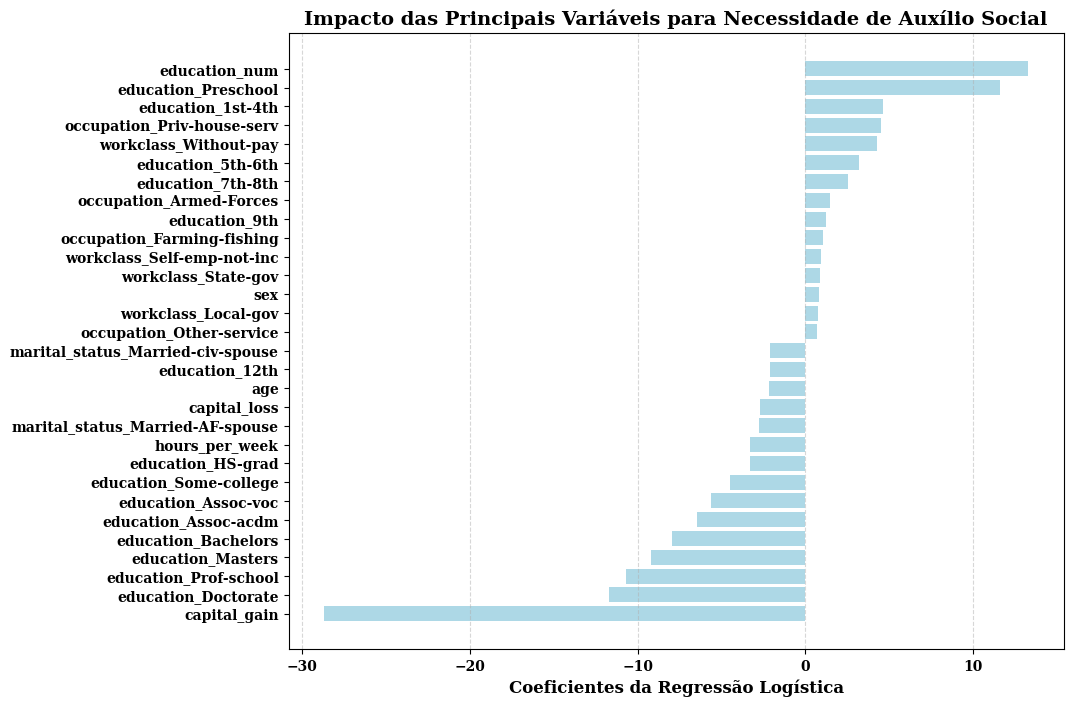

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
coefficients = lr_tun.coef_[0]
features = x_train.columns

sorted_idx = np.argsort(coefficients)
sorted_coefficients = coefficients[sorted_idx]
sorted_features = features[sorted_idx]

top_n = 15
top_features = sorted_features[:top_n].tolist() + sorted_features[-top_n:].tolist()
top_coefficients = sorted_coefficients[:top_n].tolist() + sorted_coefficients[-top_n:].tolist()

plt.figure(figsize=(10, 8))
plt.barh(top_features, top_coefficients, color='lightblue')
plt.xlabel('Coeficientes da Regressão Logística', fontweight='bold', fontsize=12, fontfamily='serif')
plt.title('Impacto das Principais Variáveis para Necessidade de Auxílio Social', fontweight='bold', fontsize=14, fontfamily='serif')
plt.xticks(fontfamily='serif', fontweight='bold')
plt.yticks(fontfamily='serif', fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

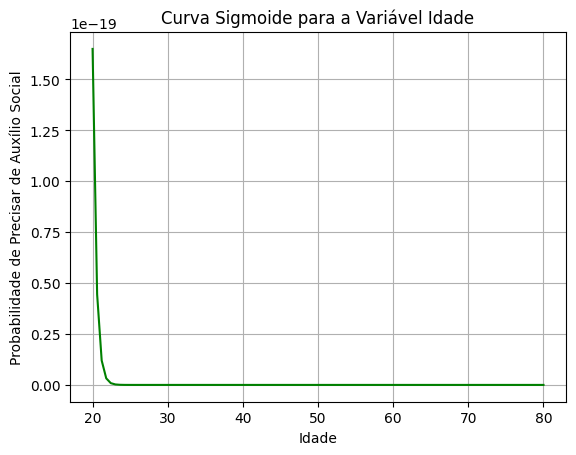

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

age_values = np.linspace(20, 80, 100)
age_coef = lr_tun.coef_[0][features.get_loc('age')]  # Coeficiente de idade
intercept = lr_tun.intercept_[0]

log_odds = intercept + age_coef * age_values
probabilities = sigmoid(log_odds)

plt.plot(age_values, probabilities, color='green')
plt.xlabel('Idade')
plt.ylabel('Probabilidade de Precisar de Auxílio Social')
plt.title('Curva Sigmoide para a Variável Idade')
plt.grid(True)
plt.show()


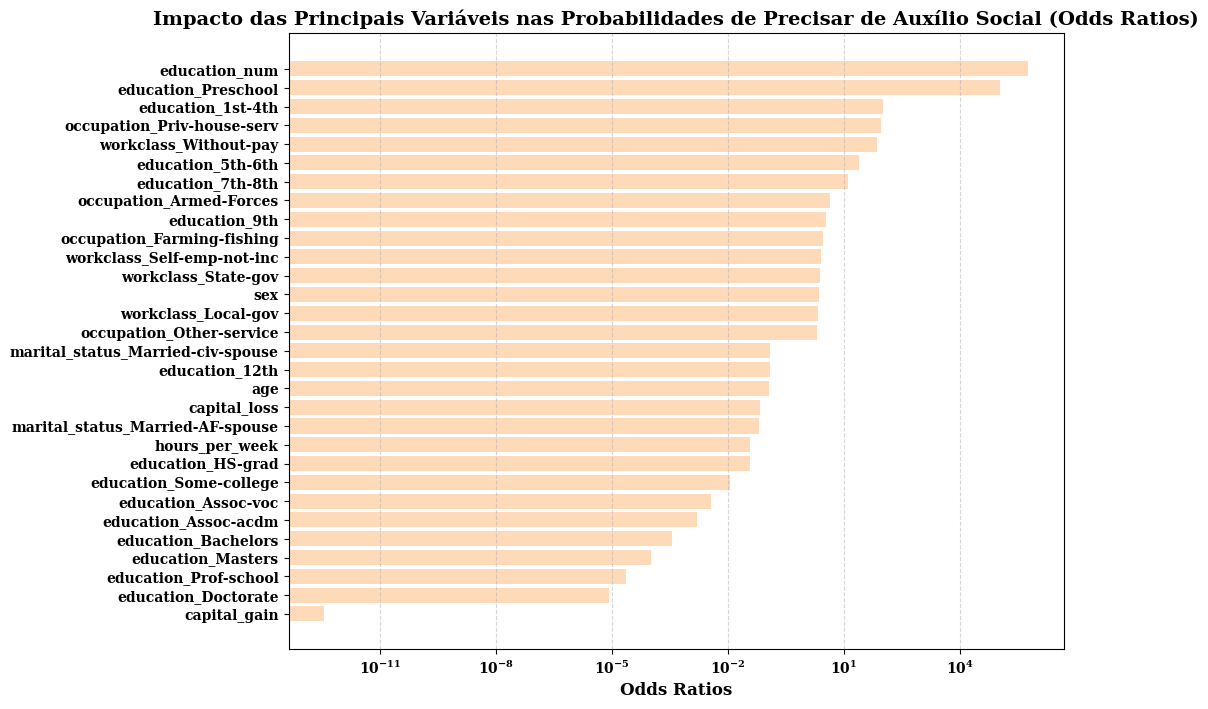

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

odds_ratios = np.exp(coefficients)

sorted_odds_ratios = odds_ratios[sorted_idx]

top_odds_ratios = sorted_odds_ratios[:top_n].tolist() + sorted_odds_ratios[-top_n:].tolist()
top_features_odds = sorted_features[:top_n].tolist() + sorted_features[-top_n:].tolist()

plt.figure(figsize=(10, 8))
plt.barh(top_features_odds, top_odds_ratios, color='peachpuff')  # Tom pastel laranja
plt.xlabel('Odds Ratios', fontweight='bold', fontsize=12, fontfamily='serif')
plt.title('Impacto das Principais Variáveis nas Probabilidades de Precisar de Auxílio Social (Odds Ratios)', 
          fontweight='bold', fontsize=14, fontfamily='serif')
plt.xscale('log')  # Escala logarítmica para melhor visualização
plt.xticks(fontfamily='serif', fontweight='bold')
plt.yticks(fontfamily='serif', fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()



## Explicabilidade para Random Forest

In [12]:
import shap

In [15]:
rf_tun = loaded_models['rf']

In [16]:
rf_tun

RandomForestClassifier(max_depth=21, min_samples_leaf=3, n_estimators=422)

In [ ]:
explainer = shap.TreeExplainer(rf_tun)

In [ ]:
# shap_values = explainer.shap_values(x_val)

: 

: 

In [ ]:
# shap_values.shape

(4525, 54, 2)

### Salvando e Carregnando as Explicações Obtidas

In [28]:
# import pickle
# with open('shap_values.pkl', 'wb') as file:
#     pickle.dump(shap_values, file)

In [15]:
import pickle


with open('shap_values//shap_values.pkl', 'rb') as file:
    shap_values_loaded = pickle.load(file)

In [16]:
shap_values_loaded.shape

(4525, 54, 2)

In [17]:
shap_values_loaded

array([[[-0.10549884,  0.10549884],
        [-0.00455245,  0.00455245],
        [ 0.12396342, -0.12396342],
        ...,
        [ 0.00713216, -0.00713216],
        [ 0.00125311, -0.00125311],
        [-0.00232766,  0.00232766]],

       [[ 0.03848178, -0.03848178],
        [-0.00187693,  0.00187693],
        [-0.03950383,  0.03950383],
        ...,
        [ 0.00667961, -0.00667961],
        [ 0.00631225, -0.00631225],
        [-0.0035158 ,  0.0035158 ]],

       [[ 0.04251157, -0.04251157],
        [-0.00430407,  0.00430407],
        [-0.04337956,  0.04337956],
        ...,
        [ 0.00531078, -0.00531078],
        [ 0.00422247, -0.00422247],
        [-0.00241272,  0.00241272]],

       ...,

       [[ 0.01903254, -0.01903254],
        [-0.00377358,  0.00377358],
        [-0.06038246,  0.06038246],
        ...,
        [ 0.00324081, -0.00324081],
        [-0.02361098,  0.02361098],
        [-0.00467537,  0.00467537]],

       [[ 0.04157602, -0.04157602],
        [-0.00138649,  0.00

## Explicação Local Para o Tree SHAP

In [43]:
import numpy as np

# Se não tiver o valor esperado do `explainer`, use a média dos valores SHAP
expected_value = np.mean(shap_values_loaded[:, :, classe])

# Plote o gráfico de força com a ordem correta dos parâmetros
shap.force_plot(
    base_value=expected_value,  # Coloque diretamente como o primeiro parâmetro
    shap_values=shap_values_loaded[obs, :, classe],
    features=x_val.iloc[obs]  # Certifique-se de que `x_val` esteja carregado corretamente
)

In [13]:
# import shap
# obs = 0  # Exemplo: primeira observação do conjunto de validação

# # Gráfico de força SHAP para uma previsão específica
# shap.initjs()
# shap.force_plot(explainer.expected_value[1], shap_values_loaded[obs, :, 1], x_val.iloc[obs])


In [14]:
# import shap
# obs = 0  # Índice da observação
# shap.waterfall_plot(shap.Explanation(values=shap_values_loaded[obs, :, 1], 
#                                      base_values=explainer.expected_value[1], 
#                                      data=x_val.iloc[obs],
#                                      feature_names=x_val.columns))

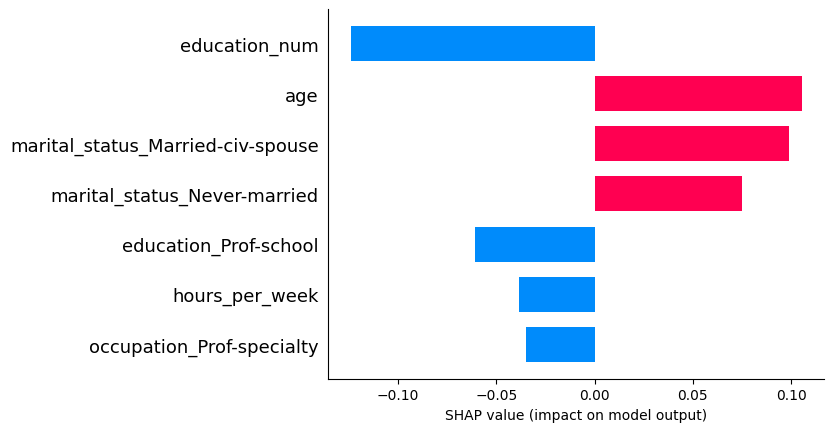

In [48]:
shap.bar_plot(shap_values_loaded[obs, :, 1], feature_names=x_val.columns)


## Explicação Global para o Tree SHAP

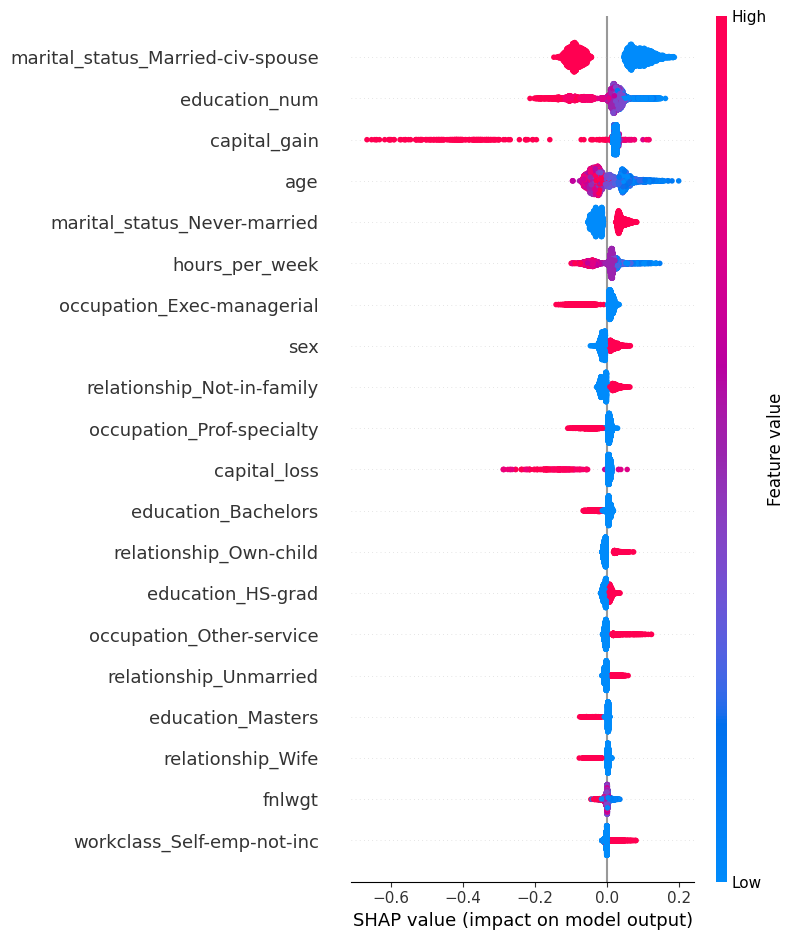

In [61]:
# shap.beeswarm_plot(shap_values[1], x_val, feature_names=X_val.columns)
# Selecionar os valores SHAP para a classe 1 (pessoas que precisam de auxílio social)
shap_values_class_1 = shap_values_loaded[:, :, 1]

# Gerar o Summary Plot
shap.summary_plot(shap_values_class_1, x_val, feature_names=x_val.columns)

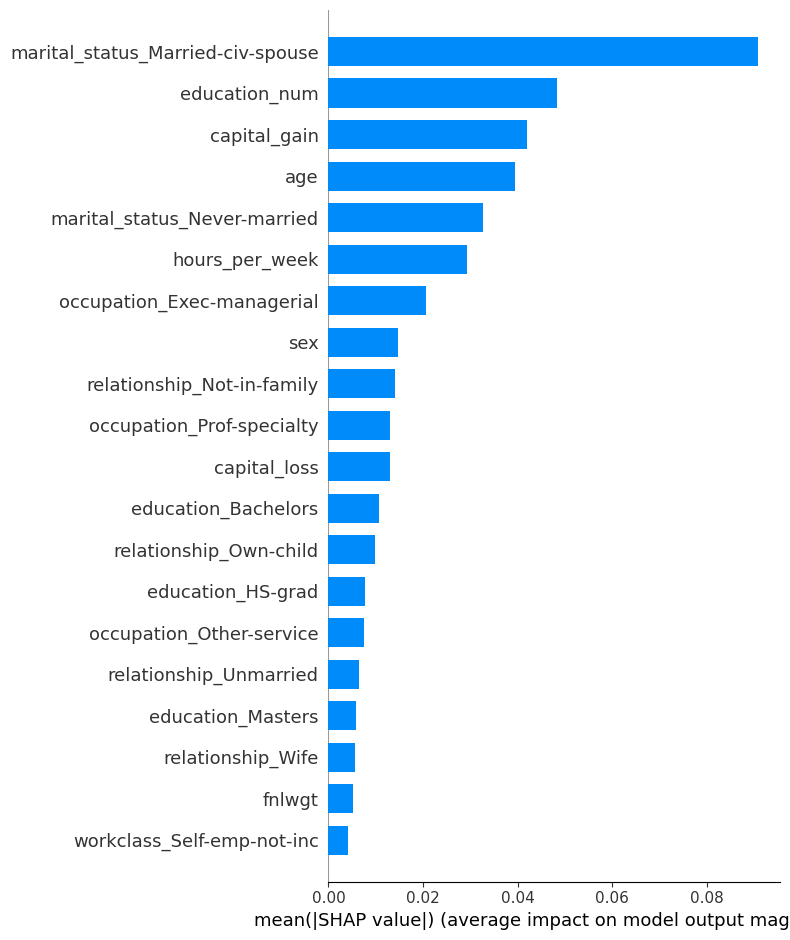

In [64]:
# Gerar o Bar Plot
shap.summary_plot(shap_values_class_1, x_val, feature_names=x_val.columns, plot_type="bar")


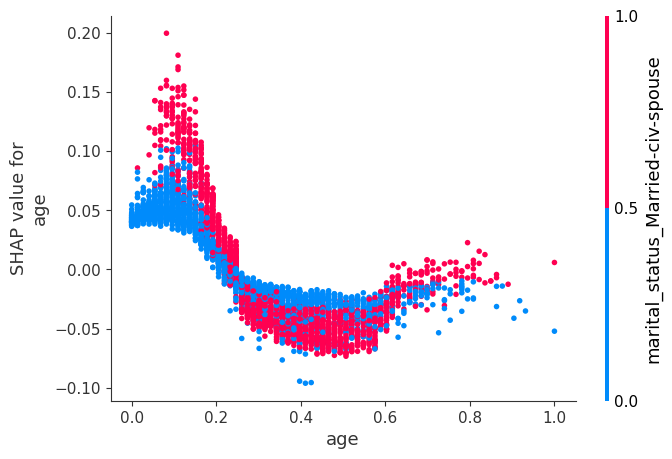

In [65]:
# Gerar o Gráfico de Dependência para a variável 'age'
shap.dependence_plot('age', shap_values_class_1, x_val)


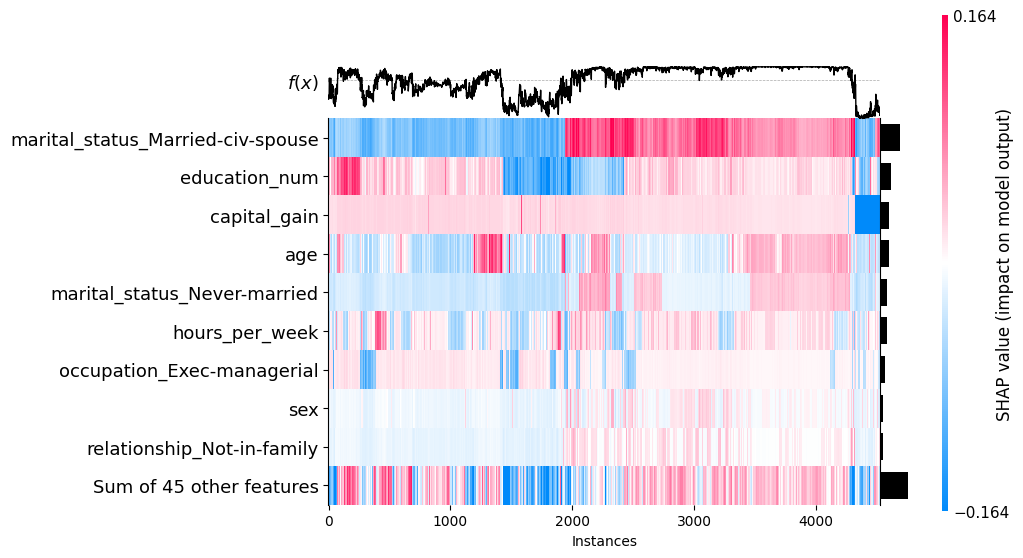

<Axes: xlabel='Instances'>

In [68]:
import shap

# Converter o array SHAP para um objeto Explanation, com as variáveis e os nomes das features
shap_values_expl = shap.Explanation(values=shap_values_class_1, 
                                    base_values=explainer.expected_value[1], 
                                    data=x_val, 
                                    feature_names=x_val.columns)

# Agora gerar o Heatmap com o novo objeto Explanation
shap.plots.heatmap(shap_values_expl)

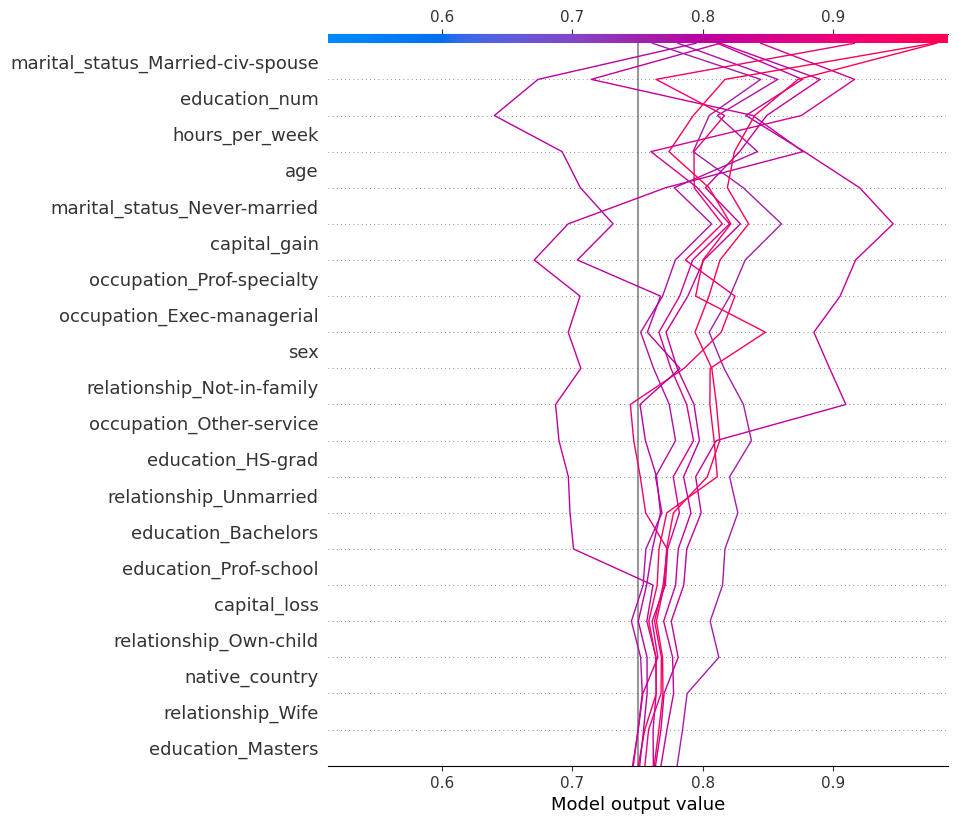

In [67]:
# Gerar o Decision Plot para as 10 primeiras observações
shap.decision_plot(explainer.expected_value[1], shap_values_class_1[:10], x_val.iloc[:10])


## Modelo Novo - Tree Interpreter

In [15]:
pip install treeinterpreter

Note: you may need to restart the kernel to use updated packages.


In [16]:
from treeinterpreter import treeinterpreter as ti
warnings.filterwarnings("ignore", message="X has feature names, but .* was fitted without feature names")

# Treinar o modelo de RandomForest

# Usar o treeinterpreter para explicar as predições
instances = x_val[:10]  # Pegue algumas amostras para demonstração
prediction, bias, contributions = ti.predict(rf_tun, instances)

# Exibir os resultados
for i in range(len(instances)):
    print(f"Amostra {i+1}:")
    print(f"  Predição: {prediction[i]}")
    print(f"  Valor base (Bias): {bias[i]}")
    print("  Contribuições das características:")
    for j, feature_contrib in enumerate(contributions[i]):
        print(f"    Feature {j}: {feature_contrib}")
    print("\n")

Amostra 1:
  Predição: [0.18656196 0.81343804]
  Valor base (Bias): [0.24931199 0.75068801]
  Contribuições das características:
    Feature 0: [-0.13594057  0.13594057]
    Feature 1: [ 0.00116469 -0.00116469]
    Feature 2: [ 0.13155203 -0.13155203]
    Feature 3: [ 0.00013508 -0.00013508]
    Feature 4: [ 0.01114772 -0.01114772]
    Feature 5: [-0.02750795  0.02750795]
    Feature 6: [-0.003217  0.003217]
    Feature 7: [ 0.05650275 -0.05650275]
    Feature 8: [-0.00133292  0.00133292]
    Feature 9: [ 0.00095487 -0.00095487]
    Feature 10: [-0.01057824  0.01057824]
    Feature 11: [-0.00214869  0.00214869]
    Feature 12: [-0.00784215  0.00784215]
    Feature 13: [ 0.00229981 -0.00229981]
    Feature 14: [0. 0.]
    Feature 15: [ 3.75633919e-05 -3.75633919e-05]
    Feature 16: [-1.5041429e-05  1.5041429e-05]
    Feature 17: [ 3.39744232e-06 -3.39744232e-06]
    Feature 18: [ 3.29728171e-06 -3.29728171e-06]
    Feature 19: [-1.77831822e-05  1.77831822e-05]
    Feature 20: [ 2.46039

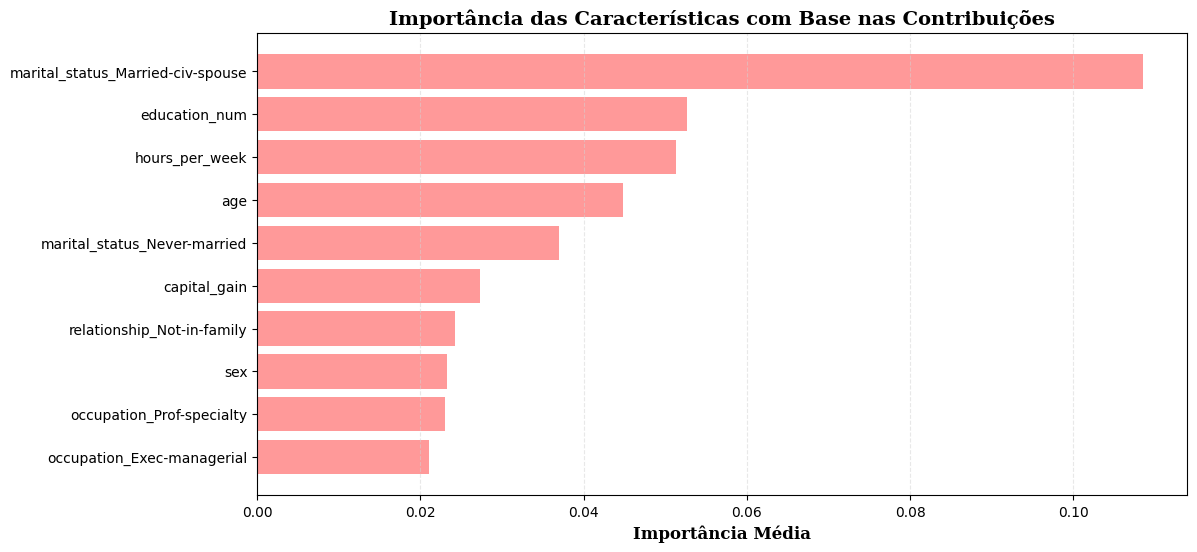

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
import warnings

warnings.filterwarnings("ignore", message="X has feature names, but .* was fitted without feature names")

def plot_feature_importances(instances, model, x_val, top_n=None):
    """
    Plota as importâncias das características com base nas contribuições do treeinterpreter.

    Args:
    - instances: Amostras para as quais as contribuições são calculadas.
    - model: Modelo treinado a ser interpretado.
    - x_val: DataFrame de validação contendo os dados.
    - top_n: Número de variáveis mais importantes a serem mostradas. Se None, mostra todas.
    """
    # Usar o treeinterpreter para explicar as predições
    prediction, bias, contributions = ti.predict(model, instances)

    # Verifique as dimensões de contributions
    if contributions.ndim == 3 and contributions.shape[2] == 2:
        # Calcular a média das contribuições para a primeira classe (classe positiva)
        mean_contributions = np.mean(np.abs(contributions[:, :, 1]), axis=0)
    else:
        mean_contributions = np.mean(np.abs(contributions), axis=0)

    # Obter os nomes das features
    feature_names = x_val.columns if isinstance(x_val, pd.DataFrame) else [f'Feature {i}' for i in range(x_val.shape[1])]

    # Criar DataFrame para ordenar as importâncias
    df_importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_contributions
    }).sort_values(by='Importance', ascending=False)

    # Mostrar apenas as top_n variáveis mais importantes, se especificado
    if top_n is not None:
        df_importances = df_importances.head(top_n)

    # Estilizar o gráfico com fonte serifada e tons pastéis
    plt.figure(figsize=(12, 6))
    plt.barh(df_importances['Feature'], df_importances['Importance'], color='#ff9999')  # Tom pastel de vermelho
    plt.xlabel('Importância Média', fontweight='bold', fontsize=12, family='serif')
    plt.title('Importância das Características com Base nas Contribuições', fontweight='bold', fontsize=14, family='serif')
    plt.gca().invert_yaxis()

    # Estilizar o grid com linhas tracejadas suaves
    plt.grid(axis='x', linestyle='--', alpha=0.5, color='#d3d3d3')  # Tom mais claro para o grid
    plt.show()

# Exemplo de uso
plot_feature_importances(x_val[:10], rf_tun, x_val, top_n=10)  # Mostra as 10 variáveis mais importantes


In [ ]:
print("Dimensões de contributions:", contributions.shape)

Dimensões de contributions: (10, 54, 2)


## Contrafactual - Dice

In [ ]:
# os.chdir('drive/MyDrive/IA Ética/Atividade 3')

In [ ]:
pip install dice-ml

In [ ]:
# Importar os modelos já treinados
import joblib
loaded_models = {}
for name in ['rf','nb','knn','SVC','lr']:
    loaded_models[name] = joblib.load(f'models//{name}_model.pkl')

rf_tun = loaded_models['rf']

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianNB from version 1.5.1 when using version 1.5.2. This might lead to break

In [ ]:
import pandas as pd

# Garantindo que o y_train tenha o nome da coluna definido como 'target'
y_train_df = y_train.rename("target") if isinstance(y_train, pd.Series) else y_train

# Combinar x_train e y_train_df
train_data = pd.concat([x_train, y_train_df], axis=1)


In [ ]:
import pandas as pd


if isinstance(y_train, pd.DataFrame):
    y_train_df = y_train.rename(columns={y_train.columns[0]: "target"})
# Verifica se y_train é uma Series e renomeia se necessário
elif isinstance(y_train, pd.Series):
    y_train_df = y_train.rename("target")
else:
    raise ValueError("y_train must be a pandas DataFrame or Series")

train_data = pd.concat([x_train, y_train_df], axis=1)

In [ ]:
import dice_ml
from dice_ml import Dice

# Configurar os dados para o DiCE
data = dice_ml.Data(dataframe=train_data, continuous_features=x_train.columns.tolist(), outcome_name='target')

model = dice_ml.Model(model=rf_tun, backend="sklearn")

# Inicializar o DiCE com dados e modelo
exp = Dice(data, model)

sample = x_val.iloc[0:1]  # substitua pelo índice da amostra desejada
counterfactuals = exp.generate_counterfactuals(sample, total_CFs=5, desired_class="opposite")
counterfactuals.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00,  1.37it/s]

Query instance (original outcome : 1)


,age,fnlwgt,education_num,race,sex,capital_gain,capital_loss,hours_per_week,native_country,workclass_Local-gov,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,target
0,0.150685,76714,0.933333,0,0,0.0,0.0,0.55102,0,0,...,0,0,0,0,1,0,0,0,0,1



Diverse Counterfactual set (new outcome: 0)


,age,fnlwgt,education_num,race,sex,capital_gain,capital_loss,hours_per_week,native_country,workclass_Local-gov,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,target
0,0.150685,76714,0.933333,0,0,0.1,0.0,0.55102,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.392451,76714,0.933333,0,0,0.0,0.0,0.55102,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.150685,76714,0.933333,0,0,0.1,0.0,0.55102,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.150685,76714,0.933333,0,0,0.9,0.0,0.55102,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.150685,76714,0.933333,1,0,0.5,0.0,0.55102,0,0,...,0,0,0,0,1,0,0,0,0,0
